# Assignment 1
## Instructions
* This is an individual assignment. You are not allowed to discuss the problems with other students.
* Part of this assignment will be autograded by gradescope. You can use it as immediate feedback to improve your answers. You can resubmit as many times as you want.
* All your solution, code, analysis, graphs, explanations should be done in this same notebook.
* Please make sure to execute all the cells before you submit the notebook to the gradescope. You will not get points for the plots if they are not generated already.
* If you have questions regarding the assignment, you can ask for clarifications in Piazza. You should use the corresponding tag for this assignment.

**Warning:** Throughout the assignment, you will be asked to implement certain algorithms and find optimal values. In the solution you submit, do not simply call a library function which performs the entire algorithm for you, this is forbidden, as it would obviously defeat the purpose. For example, if you were asked to implement the PCA algorithm, do not simply call `sklearn.decomposition.PCA` on the given data and submit that as your solution.

## Context
In this assigment you will learn to:
1. Implement a linear regression model
2. Train it using a gradient decent optimizer
3. Understand how to optimize hyperparameters

The data you will be working with comes from a solar power plant. In order to keep the energy grid stable, it is important to produce enough power. A solar power plant produces energy depending on the weather and the time of the day, the remaning power requirements can be fulfilled using a fossil fuel power plant. Unfortunately, a fossil fuel power plant can not change its power output instantaneously depending on the what the solar power plant produces. It is therefore important to be able to predict what the solar power plant will produce, to avoid either producing too little or too much power using a fossil fuel power plant. If we can provide accuate predictions, we can avoid an unstable energy grid and prevent unnecessary carbon-emissions.

In the dataset we provide, you are given the `time` (in days) and a forecast of the `temperature` (in Celsius) and should predict the `power` output (kilo Watts).

_The code below is just setup that we will need later, you do not need to understand it to complete the assignment. Although, RMSE error and data shuffling is part of the curriculum._

In [1]:
!rm -rf public

In [2]:
!pip install otter-grader
!git clone https://github.com/chandar-lab/INF8245e-assignments-public.git public

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 167 kB 7.6 MB/s 
     |████████████████████████████████| 297 kB 47.2 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
Cloning into 'public'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 111 (delta 62), reused 87 (delta 50), pack-reused 0
Receiving objects: 100% (111/111), 116.69 KiB | 8.98 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True, tests_dir='./public/assignment_1_python/tests')

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import plotnine as p9
from IPython.display import display

def rmse(y, y_pred):
    return np.sqrt(((y - y_pred) ** 2).mean())

t_distribution = np.load('./public/assignment_1_python/data/t-distribution.npy')

def confidence_interval(column_name):
    def agg(partial_df):
        data = partial_df.loc[:, column_name].to_numpy()
        obs = len(data)
        mean = np.mean(data)
        sem = np.std(data) / np.sqrt(obs)
        ppf = t_distribution[min(len(t_distribution) - 1, obs - 1)]

        return pd.Series({
            f'{column_name}_lower': mean - ppf * sem,
            f'{column_name}_mean': mean,
            f'{column_name}_upper': mean + ppf * sem
        })
    return agg

def shuffle(y, X, seed=0):
    obs = X.shape[0]
    rng = np.random.default_rng(seed)
    perm = rng.permutation(obs)
    y = y[perm, :]
    X = X[perm, :]
    return (y, X)

# 1. Understand your data (10 points)

In this section you will: 
1. Hypothesis a simple linear model.
2. Describe a linear model using matrix-vector notation.

To get you started, we load the data and plot it for you.

In [5]:
data_all = pd.read_csv(f'./public/assignment_1_python/data/dataset.csv')
data_all[24:36]

,power,time,temperature
24,0.448642,0.250000,24.088446
25,2.924810,0.260417,24.011635
26,6.941434,0.270833,23.976731
27,13.012086,0.281250,24.218990
28,18.793597,0.291667,24.537398
29,20.256458,0.302083,24.815960
30,19.826951,0.312500,24.988790
31,20.179951,0.322917,25.216180
32,29.470365,0.333333,25.419513
33,46.335071,0.343750,25.959082


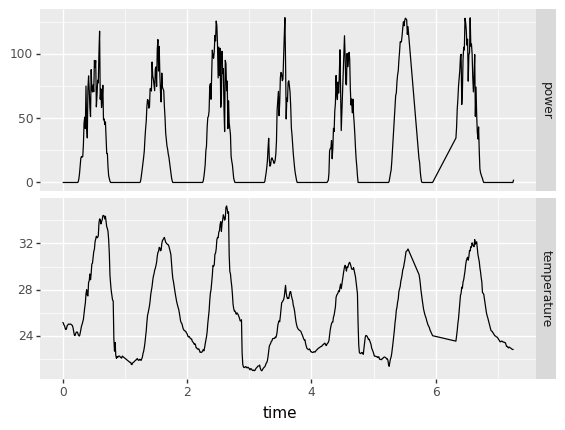

In [6]:
p = (p9.ggplot(data_all.melt(id_vars=['time']), p9.aes(x='time', y='value'))
 + p9.geom_line()
 + p9.facet_grid('variable ~ ', scales='free_y')
 + p9.labs(y='')
 + p9.theme(subplots_adjust={'wspace': 0.25}))
print(p)

As we can see, the power and temperature are plotted as a function of time, where the x-axis is the number of days and midnight happens at each integer starting from 0.

<!-- BEGIN QUESTION -->

**Question 1a (5 points):** How might we model the $power$ given the $temperature$ and $time$ using a linear regression model? (Many valid answers).

$power = \text{weight}_1 \cdot \text{time} + \text{weight}_2 \cdot sin(2 \pi \times \text{time}) + \text{weight}_3 \cdot cos(3\pi \times \text{time}) + \text{weight}_4 \cdot \text{temperature}   + \text{bias}$

The above model is decided because power shows a periodic but not harmonic pattern with time. A combination of cosine and sine curves are used to describe this dependency between power and time. On the other side, temperature shows a similar changing tendency as power, with periodic but not harmonic pattern, so a linear relation between temperature and power is assumed with the term of first order regressor.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 1b (5 points):** Consider the model $power = a \cdot temperature + b \cdot temperature^2 + c$, rewrite this to matrix form $y = X w$ by defining $X$ and $w$.

$X = \begin{bmatrix} temperature & \ temperature^2 & \ 1 & \end{bmatrix}$

$w = \begin{bmatrix} a \\ b \\ c \end{bmatrix}$

$y = Xw = \begin{bmatrix} temperature & \ temperature^2 & \ 1 & \end{bmatrix} \begin{bmatrix} a \\ b \\ c \end{bmatrix}  =a \cdot temperature + b \cdot temperature^2 + c$

<!-- END QUESTION -->

# 2. Simple linear regression (32.5 points)

In this section you will:
1. Understand how to build a design matrix.
1. Implement a linear regression model.

**Question 2a (5 points):** Implement a design matrix that represents $X = [temperature, 1]$:

In [7]:
def design_matrix_simple(temperature: np.ndarray, time: np.ndarray) -> np.ndarray:
    """Returns the design matrix [temperature,1]

    Args:
        temperature (np.ndarray): Numpy array of shape [observations]
        time (np.ndarray): Numpy array of shape [observations]

    Returns:
        np.ndarray: Numpy array of shape [observations, 2]
    """
    return np.column_stack((temperature,np.ones(np.size(temperature))))

In [8]:
grader.check("question 2a")

question 2a results: All test cases passed!

**Question 2b (5 points):** Implement a function that given a matrix $X$ (e.g. [temperature, time]) and parameters $w$ computes $y = Xw$.

In [9]:
def linear_regression_predict(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    """Computes $y = Xw$

    Args:
        X (np.ndarray): Numpy array of shape [observations, features]
        w (np.ndarray): Numpy array of shape [features, 1]

    Returns:
        np.ndarray: Numpy array of shape [observations, 1]
    """
    return np.dot(X,w)

In [10]:
grader.check("question 2b")

question 2b results: All test cases passed!

**Question 2c (10 points):** Implement a function that given $y$ (e.g. power) and $X$ (e.g. [time, temperature]) computes the optimal $w$ using the closed form solution. Do not use library functions which given $y$ and $X$ return the optimal $w$.

In [11]:
def linear_regression_optimize(y: np.ndarray, X: np.ndarray) -> np.ndarray:
    """Optimizes MSE fit of $y = Xw$

    Args:
        y (np.ndarray): Numpy array of shape [observations, 1]
        X (np.ndarray): Numpy array of shape [observations, features]

    Returns:
        Numpy array of shape [features, 1]
    """
    # For regression without regulariztion, w* obtained with MSE and SSE is the same
    return np.linalg.inv(np.dot(X.T,X)).dot(X.T).dot(y)

In [12]:
grader.check("question 2c")

question 2c results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 2d (10 points):** Using the three functions you have implemented `design_matrix_simple`, `linear_regression_predict`, and `linear_regression_optimize` we can now fit and and evaluate a linear regression.

From the results of this linear regression what issues do you identify? Is the model underfitting or overfitting?

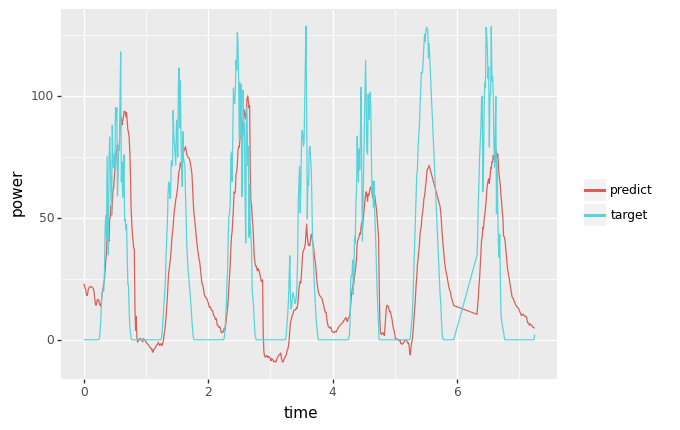

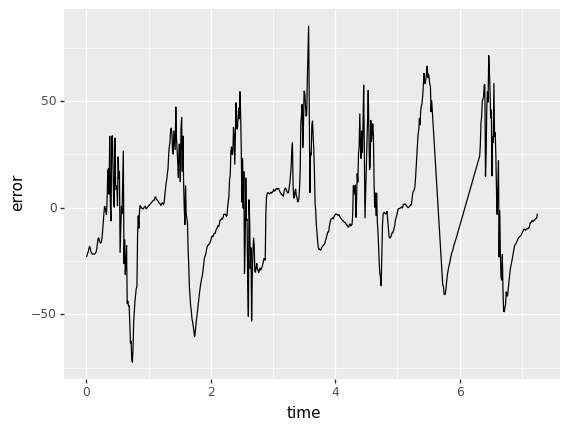

In [13]:
X = design_matrix_simple(data_all['temperature'].to_numpy(), data_all['time'].to_numpy())
y = data_all['power'].to_numpy()[:, None]
w = linear_regression_optimize(y, X)
y_pred = linear_regression_predict(X, w)

p = (p9.ggplot(data_all.assign(predict = y_pred)
                       .rename(columns={"power": "target"})
                       .drop(columns=['temperature'])
                       .melt(id_vars=['time']),
               p9.aes(x='time', y='value', color='variable'))
 + p9.geom_line()
 + p9.labs(y = 'power', color=''))
print(p)

p = (p9.ggplot(data_all.assign(error = y - y_pred),
               p9.aes(x='time', y='error'))
 + p9.geom_line())
print(p)

The issues I identify are: 
* The current model is underfitting the target. The basic function is too simple to capture well the underlying truth and give good prediction at specific point. We can observe that many of the maximum target values are not predicted by our model. Notably, the prediction model may even predict a negative power value, while the minimum power is 0 in reality.
* If we look at the Error-Time plot, we observe that prediction model may either underestimate or overestimate the power value. The error follows a similar periodic change as the power observation and it seems to be harmonic.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 2e (2.5 points):** We can model the seasonal trend using a combination of cosine and sine curves, in addition we will also consider the features $temperature$, $temperature^2$, $temperature^3$ and finally a bias parameter.

You don't need to understand the details of modelling a seasonal trend, but the basic idea is that lowest frequency we wish to model is one day. We can model this with $a \cdot cos(2 \pi \cdot time) + b \cdot sin(2 \pi \cdot time)$. By fitting $a$ and $b$ we can represent any phase and amplitude.

$X_{seasonal} = \begin{bmatrix} \cos(2 \pi \cdot 1 \cdot time), & \sin(2 \pi \cdot 1 \cdot time), & \cdots, & \cos(2 \pi \cdot 48 \cdot time), & \sin(2 \pi \cdot 48 \cdot time) \end{bmatrix}$

_You don't need to understand this:_ As you will see we can benift from modelling higher frequencies too. Because our data is collected every 15 minutes and due to something called the [Nyquist-Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) the highest frequency we can model is every 30 minutes. We will therefore consider all periods between $1$ and $24*2$.

What issues do you observe, what would you suggest to futher improve the model?


In [14]:
def design_matrix_seasonal(temperature: np.ndarray, time: np.ndarray) -> np.ndarray:
    """Returns the design matrix [1, temperature]

    Args:
        temperature (np.ndarray): Numpy array of shape [observations]
        time (np.ndarray): Numpy array of shape [observations]

    Returns:
        np.ndarray: Numpy array of shape [observations, 2]
    """
    features = []

    for power in range(1, 4):
        features.append( temperature**power )

    for period in range(1, 24*2 + 1):
        features.append( np.cos(2*np.pi * period * time) )
        features.append( np.sin(2*np.pi * period * time) )
    
    features.append( np.ones_like(temperature) )

    return np.hstack([feature[:, None] for feature in features])


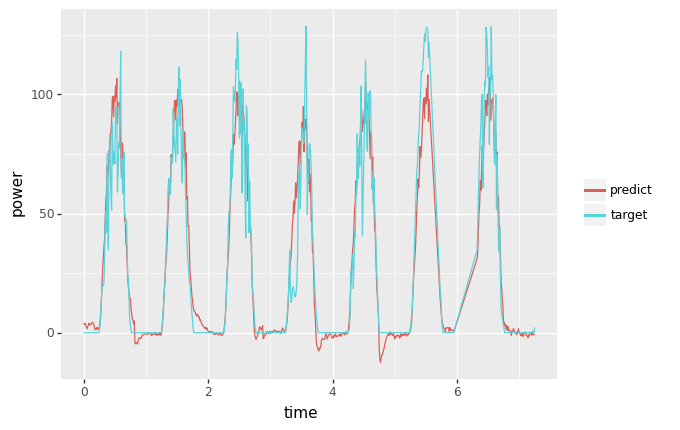

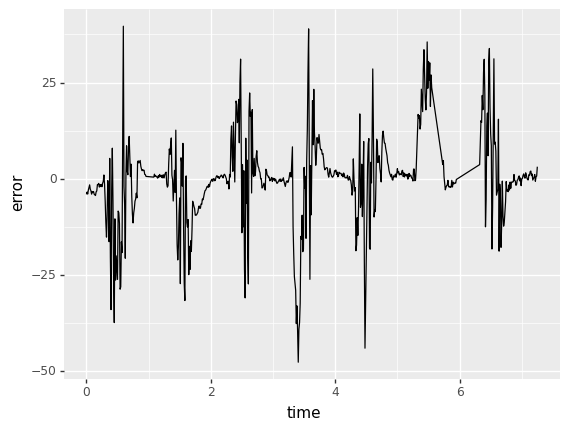

In [15]:
X = design_matrix_seasonal(data_all['temperature'].to_numpy(), data_all['time'].to_numpy())
y = data_all['power'].to_numpy()[:, None]
w = linear_regression_optimize(y, X)
y_pred = linear_regression_predict(X, w)

p = (p9.ggplot(data_all.assign(predict = y_pred)
                       .rename(columns={"power": "target"})
                       .drop(columns=['temperature'])
                       .melt(id_vars=['time']),
               p9.aes(x='time', y='value', color='variable'))
 + p9.geom_line()
 + p9.labs(y = 'power', color=''))
print(p)

p = (p9.ggplot(data_all.assign(error = y - y_pred),
               p9.aes(x='time', y='error'))
 + p9.geom_line())
print(p)

The issues I observe are:
* The model is very likely to overfit the dataset. Most of the error fails into 0. The proposed model is fitting most of the point in the data set. Here we do not have a validation set so we do not actually know how general our model can describe our target variable. But considering the complexity of our model, it is probably overfitting.
* The prediction model sometimes predicts a negative value for power.
* The prediction model can not capture the maximum value.

To solve this I suggests:
* Use regulariztion to restrict the parameter and employ validation set to prevent overfitting.
* For the negative value predicted by our model, we can truncate them at 0
* Use a Gaussian basis function to reduce the prediction noise.

<!-- END QUESTION -->

# 3. Ridge Regression and Cross Validation (55 points)

In this section you will:
1. Learn to implement Ridge Regression.
2. Implement Cross Validation.
3. Use Cross Validation to optimize a hyperparameter.
4. Learn to think about correct validation and testing practises.

**Question 3a (10 points):** Implement the closed form solution for Ridge Regression, also called Linear Regression with an L2 regularizer.

In [16]:
def ridge_regression_optimize(y: np.ndarray, X: np.ndarray, hyperparameter: float) -> np.ndarray:
    """Optimizes MSE fit of $y = Xw$ with L2 regualization

    Args:
        y (np.ndarray): Numpy array of shape [observations, 1]
        X (np.ndarray): Numpy array of shape [observations, features]
        hyperparameter (float): Lambda used in L2 regularization

    Returns:
        Numpy array of shape [features, 1]
    """

    n,m=np.shape(X)
    return np.linalg.inv(np.dot(X.T,X)+n*hyperparameter*np.identity(m)).dot(X.T).dot(y)

In [17]:
grader.check("question 3a")

question 3a results: All test cases passed!

**Question 3b (20 points):** Implement n-fold cross validation:

In [18]:
def cross_validation(y: np.ndarray, X: np.ndarray, splits=3, seed=0):
    """Generates cross validation splits 

    Args:
        y (np.ndarray): Numpy array of shape [observations, 1]
        X (np.ndarray): Numpy array of shape [observations, features]
        splits (int): The number of cross validation splits
        seed (int): The random seed used to shuffle the data.

    Yields:
        Tuple[
            Tuple[np.ndarray, np.ndarray],
            Tuple[np.ndarray, np.ndarray],
        ]: Two (y, X) tuples. First the training split, then the validation split.
    """
    obs = X.shape[0]

    # Because the dataset is not iid. wrt. the index,
    # it is important to shuffle it
    rng = np.random.default_rng(seed)
    perm = rng.permutation(obs)
    y = y[perm, :]
    X = X[perm, :]

    val_size=round(obs/splits)

    for split in range(splits):
        y_valid=y[split*val_size:(split+1)*val_size]
        y_train=np.delete(y,slice(split*val_size,(split+1)*val_size),axis=0)

        X_valid=X[split*val_size:(split+1)*val_size]
        X_train=np.delete(X,slice(split*val_size,(split+1)*val_size),axis=0)
        yield ((y_train, X_train), (y_valid, X_valid))


In [19]:
grader.check("question 3b")

question 3b results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 3c (20 points):** Using the `cross_validation` function and the `ridge_regression_optimize` function you implemented, implement and perform a hyperparameter search on the regularization term of the Ridge Regression. Plot the RMSE error as a function of the hyperparameter value. For approximately which value is the RMSE error lowest?

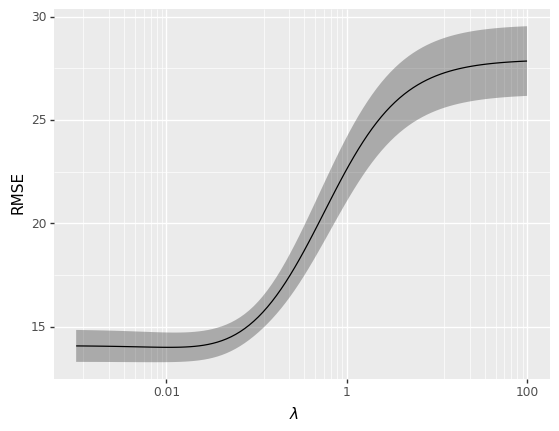

In [20]:
X = design_matrix_seasonal(data_all['temperature'].to_numpy(), data_all['time'].to_numpy())
y = data_all['power'].to_numpy()[:, None]

cv_results = []

split=[]
hyperparameter=[]
RMSE=[]

n_splits=5
ld=np.logspace(start=-3,stop=2,num=100) 

for i in range(len(ld)):
  folders=cross_validation(y, X, splits=n_splits)
  for index, folder in enumerate(folders):
    w_ridge=ridge_regression_optimize(folder[0][0], folder[0][1], ld[i])
    y_pred_ridge=linear_regression_predict(folder[1][1],w_ridge)
    error=rmse(folder[1][0],y_pred_ridge)

    hyperparameter.append(ld[i])
    RMSE.append(error)
    split.append(index)

cv_results={'split':split,'lambda':hyperparameter,'RMSE':RMSE}

cv_results = pd.DataFrame(cv_results)
#display(cv_results)

# cv_results is a pandas DataFrame with the columns
#  split: the corss validation split as an integer
#   Doubt: What is the meaning of split, not clear
#  lambda: the hyperparameter as a float
#  RMSE: the validation RMSE error

p = (p9.ggplot(cv_results.groupby(['lambda'])
                         .apply(confidence_interval('RMSE'))
                         .reset_index(),
               p9.aes(x='lambda'))
 + p9.geom_ribbon(p9.aes(ymin='RMSE_lower', ymax='RMSE_upper'), alpha=0.35)
 + p9.geom_line(p9.aes(y='RMSE_mean'))
 + p9.labs(y='RMSE', x='$\\lambda$')
 + p9.scale_x_log10())
print(p)

I would choose 0.1 as the hyperparameter, because from the RMSE-$\lambda$ plot, RMSE is relatively small before 0.1. With a hyperparameter of 0.1, $w$ is regularized to avoid overfitting, at the same time the RMSE remains small. On the other side, the confidence interval at $\lambda$=0.1 is the smallest, which indiquates that our model is more stable. Thus, it is reasonable to select 0.1 as the hyperparameter. \\
By increasing $\lambda$ value, the constraint to $w$ increase in order to prevent overfitting, but at the same time we may loose our accuracy with an increasing RMSE. Notebly, when $\lambda$ is bigger than 10, RMSE increase drastically, too much regularization will simplify too much our prediction model. Thus, we should not choose a very high value for $\lambda$. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

**Question 3d (5 points):** We can get the hyperparamter with smallest RMSE (not necessarily the best) using the following code, and compute the expected RMSE error. The code below finds the best hyperparameter correctly. However, there is a critial conceptual issue with how the error is calculated, relating to how we perform (cross) validation. What is the issue and how would you solve it?

In [21]:
# This is wrong. What is the issue?
X = design_matrix_seasonal(data_all['temperature'].to_numpy(), data_all['time'].to_numpy())
y = data_all['power'].to_numpy()[:, None]
w = ridge_regression_optimize(y, X, 5) # the hyperparameter is unimportant here, the issue is irelevant to its value
test_error = rmse(y, linear_regression_predict(X, w))
print(f'The expected RMSE test error is: {test_error:.2f}')

The expected RMSE test error is: 26.07


The issue is the porediction model is trained with the complete dataset of observation, and then RMSE is calculated with the same dataset. The prediction model have already seen the data in training. Observation in validation set should be some data that the prediction model never see. Otherwise, the RMSE cannot reflect the generalization of the prediction model. \\
I would solve this by splitting the observation data set into K folders, use k-1 folds for training and the last fold for validation. Test error is calculated by validation set and training set.

<!-- END QUESTION -->

# 4. Gradient Descent (50 points)
In this section, we will optimize our Ridge Regression model with gradient descent.

**Question 4a (10 points):** We will now use SGD to optimize our parameters instead of the closed form solution. Implement the function to compute the gradient of Ridge Regression and the following loss function:
\begin{equation}
L(X, y; w, \lambda) = \frac{1}{2N}\sum^N_{i=1} (Xw - y)_i^2 + \lambda ||w||_2^2, \text{ where } \lambda = 0.1
\end{equation}

In [22]:
def ridge_regression_gradient(y: np.ndarray, X: np.ndarray, w: np.ndarray, hyperparameter: float) -> np.ndarray:
    """Compute the gradient of w with respect to the loss
    
    Args:
        y (np.ndarray): Numpy array of shape [observations, 1]
        X (np.ndarray): Numpy array of shape [observations, features]
        w (np.ndarray): Numpy array of shape [features, 1], where the last value is w_0 and all other values represent w_1
        hyperparameter (float): Lambda used in L2 regularizer
        
    Returns:
        np.ndarray: Gradient of w with respect to the loss, as a numpy array of the same shape as w.
    """
    obs = X.shape[0]
    return 1/obs*X.T.dot((X.dot(w)-y))+2*hyperparameter*w

In [23]:
grader.check("question 4a")

question 4a results: All test cases passed!

**Question 4b (20 points):** Now that we've implemented our function to compute the gradient, let's implement the gradient descent algorithm which will iteratively call `gradient_ridge_regression` to optimize our parameters. Our function will also compute the RMSE loss with L2 regularizer at each step.

In [24]:
def ridge_regression_gradient_descent(y_train: np.ndarray, X_train: np.ndarray,
                                      y_val: np.ndarray, X_val: np.ndarray,
                                      w_init: np.ndarray, hyperparameter: float,
                                      learning_rate: float, num_steps: int) -> np.ndarray:
    """ Runs gradient descent to optimize the parameters w.
    
    Args:
        y_train (np.ndarray): Numpy array of shape [observations, 1]
        X_train (np.ndarray): Numpy array of shape [observations, features]
        y_val (np.ndarray): Numpy array of shape [observations, 1]
        X_val (np.ndarray): Numpy array of shape [observations, features]
        w_init (np.ndarray): Numpy array of shape [features, 1]
        hyperparameter (float): Lambda used in L2 regularizer
        learning_rate (float): Value to multiply our gradient with before updating our parameters.
        num_steps (int): Number of gradient descent steps to perform.
    
    Returns:
        train_loss (np.ndarray): The train RMSE loss without L2 regularizer, for each step.
        val_loss (np.ndarray): The validation RMSE loss without L2 regularizer, for each step.
        optimized_w (np.ndarray): The optimized w parameters.
    """
    train_losses = np.zeros((num_steps,), dtype=np.float32)  # You will need to update this
    val_losses = np.zeros((num_steps,), dtype=np.float32)  # You will need to update this
    w_sol = np.copy(w_init)  # You will need to update this

    for i in range(num_steps):
      train_loss=rmse(y_train,linear_regression_predict(X_train,w_sol))
      val_loss=rmse(y_val,linear_regression_predict(X_val,w_sol))
      w_sol=w_sol-learning_rate*ridge_regression_gradient(y_train, X_train, w_sol, hyperparameter)
      
      train_losses[i]=train_loss
      val_losses[i]=val_loss

    return (train_losses, val_losses, w_sol)

In [25]:
grader.check("question 4b")

question 4b results: All test cases passed!

<!-- BEGIN QUESTION -->

**Question 4c (20 points):** Using `cross_validation` with 5 splits, run `ridge_regression_gradient_descent` until you see that the loss starts to converge. For features, simply use [`temperature`, 1] and a bias. Plot both the train and validation RMSE loss with respect to the step number. Have fun trying various learning rates, but we suggest using a rather small one. Again, set $\lambda$ to 0.1

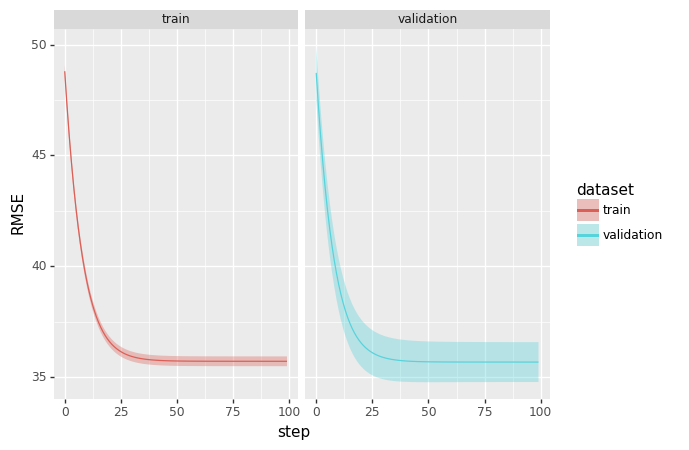

In [26]:
X = design_matrix_simple(data_all['temperature'].to_numpy(), data_all['time'].to_numpy())
y = data_all['power'].to_numpy()[:, None]

cv_results = []

#w_init=np.asarray([[1], [-200]], dtype=np.float64)
w_init=np.random.default_rng().normal(scale=0.1, size=(X.shape[1], 1))
split=[]
step=[]
train=np.array([])
validation=np.array([])

total_step=100

folders=cross_validation(y,X,splits=5,seed=0)
for index, folder in enumerate(folders):
  y_train=folder[0][0]
  X_train=folder[0][1]
  y_val=folder[1][0]
  X_val=folder[1][1]

  train_losses, val_losses, w_sol = \
  ridge_regression_gradient_descent(y_train, X_train, y_val, X_val, w_init, hyperparameter=0.1,learning_rate=1e-4, num_steps=total_step) 

  for step_n,_ in enumerate(train_losses):
    step.append(step_n)
    split.append(index)

  train=np.concatenate((train,train_losses))
  validation=np.concatenate((validation,val_losses))

cv_results={'split':split,'step':step,'train':train,'validation':validation}

cv_results = pd.DataFrame(cv_results)
# cv_results is a pandas dataframe with the columns:
#  split: the cross validation split as an integer
#  step: the optimization step as an integer
#  train: the RMSE for the training dataset as a float
#  validation: the RMSE for the validation dataset as a float

#display(cv_results)

p = (p9.ggplot(cv_results.melt(id_vars=['split', 'step'], value_vars=['train', 'validation'], var_name='dataset', value_name='RMSE')
                         .reset_index()
                         .groupby(['step', 'dataset'])
                         .apply(confidence_interval('RMSE'))
                         .reset_index(),
               p9.aes(x='step'))
 + p9.geom_ribbon(p9.aes(ymin='RMSE_lower', ymax='RMSE_upper', fill='dataset'), alpha=0.35)
 + p9.geom_line(p9.aes(y='RMSE_mean', color='dataset'))
 + p9.facet_wrap('dataset')
 + p9.labs(y='RMSE'))
print(p)


<!-- END QUESTION -->

## Linear Regression Summary

**No question:** The following code just plots the output of the three different models you have implemented. For your own sake, you should try to understand how the different models behave.

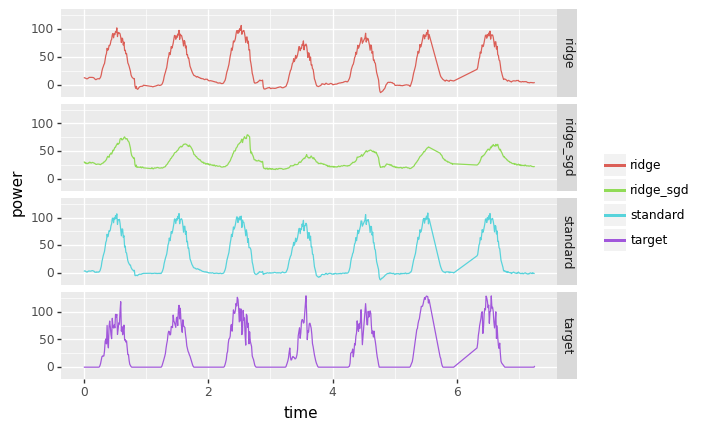

In [27]:
X = design_matrix_seasonal(data_all['temperature'].to_numpy(), data_all['time'].to_numpy())
y = data_all['power'].to_numpy()[:, None]

_, _, w_ridge_sgd = ridge_regression_gradient_descent(y, X, y, X, np.random.default_rng(41).normal(scale=0.1, size=(X.shape[1], 1)), 1e-1, 1e-9, 10000)
y_pred_ridge_sgd = linear_regression_predict(X, w_ridge_sgd)
# Doubt: why Gradient Descent gives such a poor prediction? Local minimunm

w_ridge = ridge_regression_optimize(y, X, 1E-1) # might not be the best hyperparameter
y_pred_ridge = linear_regression_predict(X, w_ridge)

w_std = linear_regression_optimize(y, X) # might not be the best hyperparameter
y_pred_std = linear_regression_predict(X, w_std)

p = (p9.ggplot(data_all.assign(ridge_sgd = y_pred_ridge_sgd, ridge=y_pred_ridge, standard=y_pred_std)
                       .rename(columns={"power": "target"})
                       .drop(columns=['temperature'])
                       .melt(id_vars=['time']),
               p9.aes(x='time', y='value', color='variable'))
 + p9.geom_line()
 + p9.labs(y = 'power', color='')
 + p9.facet_grid('variable ~'))
print(p)